# Simulate some observed galaxies

Demo of how to simulate some galaxy observations


## Packages to import

In [91]:
import sedFilter                  # handles `SED` and `Filter` objects
import cosmo                      # performs basic cosmological calculations (distances etc)
import photometry as phot         # photometry (mags/fluxes) calculations; also a cython version called cphotometry
import photErrorModel as ephot    # photometric error model


import numpy as np

# just for plotting here
import matplotlib.pyplot as plt
%matplotlib inline

##Filters

Filter transmissions are read in `BPZ` style. A text file in the `filter_data` directory lists all the filenames of the filters in that set, we use this to read the right filter data in, the file names (without extension) become the filter names.

Adding filter LSSTu to dictionary
Adding filter LSSTg to dictionary
Adding filter LSSTr to dictionary
Adding filter LSSTi to dictionary
Adding filter LSSTz to dictionary
Adding filter LSSTy to dictionary


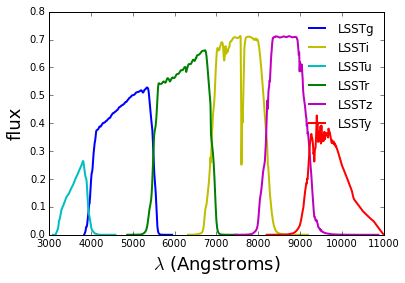

In [92]:
# file that contains a list of files that contain transmissions of each filter
listOfFilters = 'LSST.filters'
pathToFilters = '../filter_data'


# creates a dictionary: keyword is filter name (read from file list), value is a `Filter` object
filterDict = sedFilter.createFilterDict(listOfFilters, pathToFilters)

# e.g. we can plot the filters
fig = plt.figure()
ax = fig.add_subplot(111)
colors = {'LSSTu':'c','LSSTg':'b','LSSTr':'g','LSSTi':'y','LSSTz':'m', 'LSSTy':'r'}
for filtname, filt in filterDict.iteritems():

    wavelength, transmission = filt.getFilterData()
    
    ax.plot(wavelength, transmission, color=colors[filtname], linewidth=2, label=filtname)
    ax.set_xlabel(r'$\lambda$ (Angstroms)', fontsize=18)
    ax.set_ylabel(r'flux', fontsize=18)

ax.legend(loc="upper right", frameon=False)


The filter names are the indexes of the filter dictionary

In [93]:
# return the filter names
filterList = sedFilter.getFilterList(listOfFilters, pathToFilters)
print 'Filter list = ', filterList
nFilter = len(filterList)

Filter list =  ['LSSTu', 'LSSTg', 'LSSTr', 'LSSTi', 'LSSTz', 'LSSTy']


## SEDs

The method for reading the spectra in follows the method for the filters (see above).

In [94]:
# read in CWWK SEDs
listOfSedsFile = "cwwkSB.seds"
pathToFile = "/mnt/drive2/repos/PhotoZDC1/sed_data/"
sedDict = sedFilter.createSedDict(listOfSedsFile, pathToFile)
nsed = len(sedDict)
print "Read in", nsed ,"SEDs"

Adding SED El_B2004a to dictionary
Adding SED Sbc_B2004a to dictionary
Adding SED Scd_B2004a to dictionary
Adding SED Im_B2004a to dictionary
Adding SED SB3_B2004a to dictionary
Adding SED SB2_B2004a to dictionary
Adding SED ssp_25Myr_z008 to dictionary
Adding SED ssp_5Myr_z008 to dictionary
Read in 8 SEDs


Plot the Elliptical spectrum

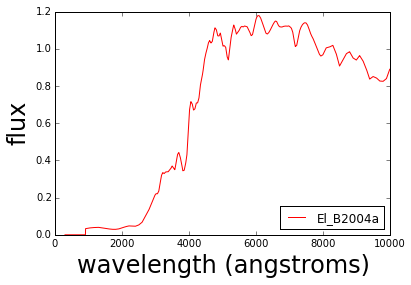

In [95]:

sed = sedDict["El_B2004a"]
wavelengths, fluxes = sed.getSedData(lamMin=300, lamMax=10000, nLam=10000)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wavelengths, fluxes, linestyle='solid', color='red', label="El_B2004a")
ax.set_xlabel('wavelength (angstroms)', fontsize=24)
ax.set_ylabel('flux', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels)
ax.legend(loc='lower right',prop={'size':12})

## Cosmology

To get a magnitude we need the luminosity distance.

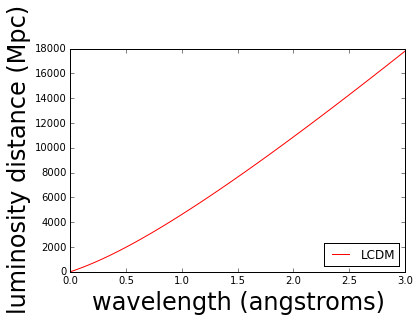

In [96]:
# (boring) cosmological model for luminosity distance
h=1.
omegamat=0.3
omegaDE=0.7
wX=-1.
wXa=0.
cosmoModel = cosmo.cosmologyCalculator(h, omegamat, omegaDE, wX, wXa)

# plot the luminosity distance
nz = 100
zmax = 3.
dz = zmax/(nz-1.)
zvals = []
Dlvals = []
for i in range(nz):
    
    z = i*dz
    zvals.append(z)
    
    cosmoModel.setEmissionRedShift(z)
    Dlvals.append(cosmoModel.LuminosityDistanceMpc())
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(zvals, Dlvals, linestyle='solid', color='red', label="LCDM")
ax.set_xlabel('wavelength (angstroms)', fontsize=24)
ax.set_ylabel('luminosity distance (Mpc)', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels)
ax.legend(loc='lower right',prop={'size':12})

#Photometric errors

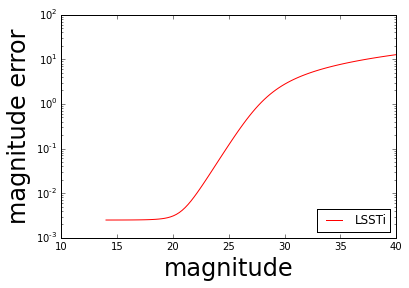

In [97]:
# LSST errors, default parameters (=median observing conditions and 1yr of observations)
LsstErrorModel = ephot.LSSTErrorModel()

# magnitude range to plot over
minMag = 14.
maxMag = 40.
nMag = 100
dMag = (maxMag - minMag)/(nMag - 1.)

mags = []
magErrors = []
for i in xrange(nMag):
    
    mag = minMag + i*dMag
    mags.append(mag)
    magErrors.append(LsstErrorModel.getMagError(mag, "LSSTi"))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(mags, magErrors, linestyle='solid', color='red', label="LSSTi")
ax.set_xlabel('magnitude', fontsize=24)
ax.set_ylabel('magnitude error', fontsize=24)
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels)
ax.legend(loc='lower right',prop={'size':12})
ax.set_yscale('log')

#Photometry


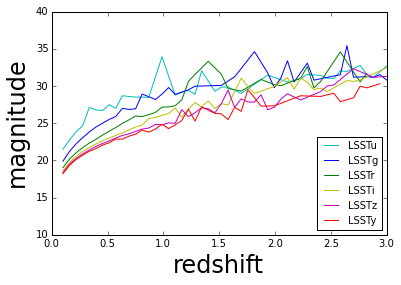

In [98]:

pLSST = phot.ObsMag(sed, filterDict, cosmoModel, LsstErrorModel)

# absolute magnitude is defined by a tuple of filter defined in and magnitude value
absMag = (filterList[3], -19.)

nz = 50
zmin = 0.1
dz = (zmax-zmin)/(nz-1.)
magLSST = np.zeros([nz, len(filterDict)+1])
for i in xrange(nz):
    z = zmin + i*dz
    
    magLSST[i, 0] = z

    for j in xrange(len(filterDict)):
        
        # LSST 1 yr error
        # observed magnitude, magnitude error, true magnitude
        m, em, mt = pLSST.simulateObservation(filterList[j], z, absMag)
       
        ii = 1 + j
        magLSST[i, ii] = m
                    
fig = plt.figure()
ax = fig.add_subplot(111)
for j in xrange(len(filterDict)):
    obsd = magLSST[:,j+1]<99.
    ax.plot(magLSST[obsd,0], magLSST[obsd,j+1], linestyle='solid', color=colors[filterList[j]], label=filterList[j])
ax.set_xlabel('redshift', fontsize=24)
ax.set_ylabel('magnitude', fontsize=24)
ax.set_ylim([10.,40.])
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels)
ax.legend(loc='lower right',prop={'size':10})

